In [1]:
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate, Multiply, Permute, Lambda, Reshape, Activation, Dropout, Add, GlobalMaxPooling1D, GlobalAvgPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import pickle
import datetime

In [2]:
# Directory containing the CSV files
csv_directory = "D:\MTdataset\DL_dataset\Python_DL\Final_current_vibration_data"

## GPU Verification

In [3]:
print(tf.__version__)
print(tf.config.experimental.list_physical_devices('GPU'))

tf.test.is_built_with_cuda()

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [4]:
# ensuring Tensorflow is using the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found. Using the CPU instead.")

# Enable mixed percision
mixed_precision.set_global_policy('mixed_float16')
tf.debugging.set_log_device_placement(True)


1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


## Load Data

In [5]:
# Load the current and vibration data
current_files = [file for file in os.listdir(csv_directory) if 'current' in file]
vibration_files = [file for file in os.listdir(csv_directory) if 'vibration' in file]

current_dfs = [pd.read_csv(os.path.join(csv_directory, file)) for file in current_files]
vibration_dfs = [pd.read_csv(os.path.join(csv_directory, file)) for file in vibration_files]

# Combine all current data and vibration data into single DataFrames
current_data = pd.concat(current_dfs, ignore_index=True)
vibration_data = pd.concat(vibration_dfs, ignore_index=True)

# Ensure your data is in the float32 format
def convert_to_float32(data):
    return data.astype(np.float32)

current_data = convert_to_float32(current_data)
vibration_data = convert_to_float32(vibration_data)

### Data preprocessing

In [ ]:
# Ensure there are no missing values
current_data = current_data.dropna()
vibration_data = vibration_data.dropna()

# Ensure data is numeric
current_data = current_data.apply(pd.to_numeric)
vibration_data = vibration_data.apply(pd.to_numeric)

# Print shapes and first few rows of raw data for debugging
print("Raw current_data shape:", current_data.shape)
print("Raw vibration_data shape:", vibration_data.shape)
print("Raw current_data head:\n", current_data.head())
print("Raw vibration_data head:\n", vibration_data.head())

Raw current_data shape: (2100007, 7)
Raw vibration_data shape: (2100007, 2)
Raw current_data head:
      Time   RotorSpeed  V_ab  I_a  I_b  I_c  OutputTorque
0  0.0000  7500.000000   0.0  0.0  0.0  0.0      0.000000
1  0.0005  7496.208984   0.0  0.0  0.0  0.0      0.000140
2  0.0010  7492.422363   0.0  0.0  0.0  0.0      0.000020
3  0.0015  7488.639160   0.0  0.0  0.0  0.0      0.000224
4  0.0020  7484.859863   0.0  0.0  0.0  0.0      0.000083
Raw vibration_data head:
      Time  RotorVibration
0  0.0000       -0.000008
1  0.0005       -0.000008
2  0.0010       -0.000340
3  0.0015        0.002847
4  0.0020        0.001061


### Data visualization

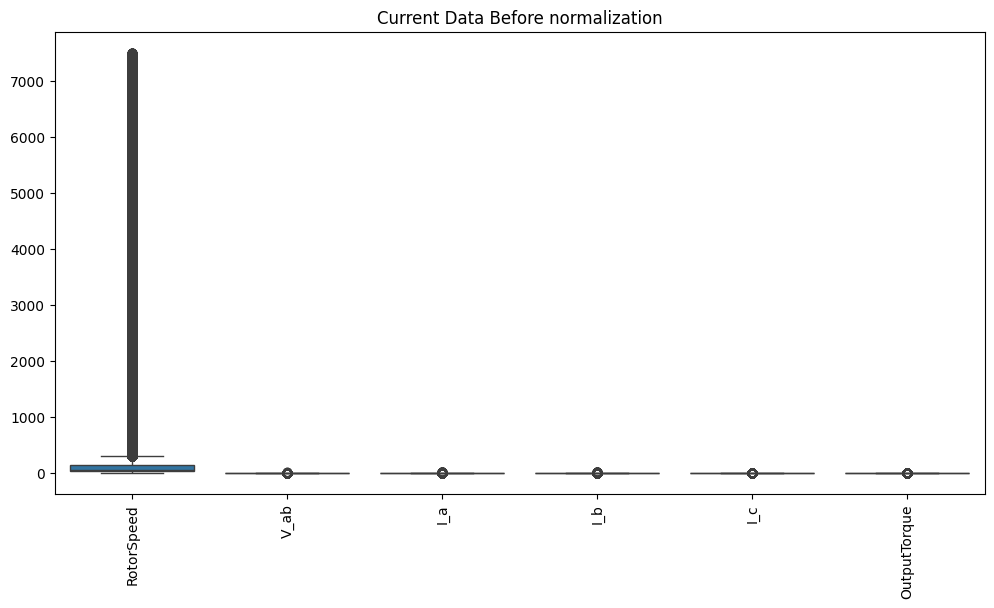

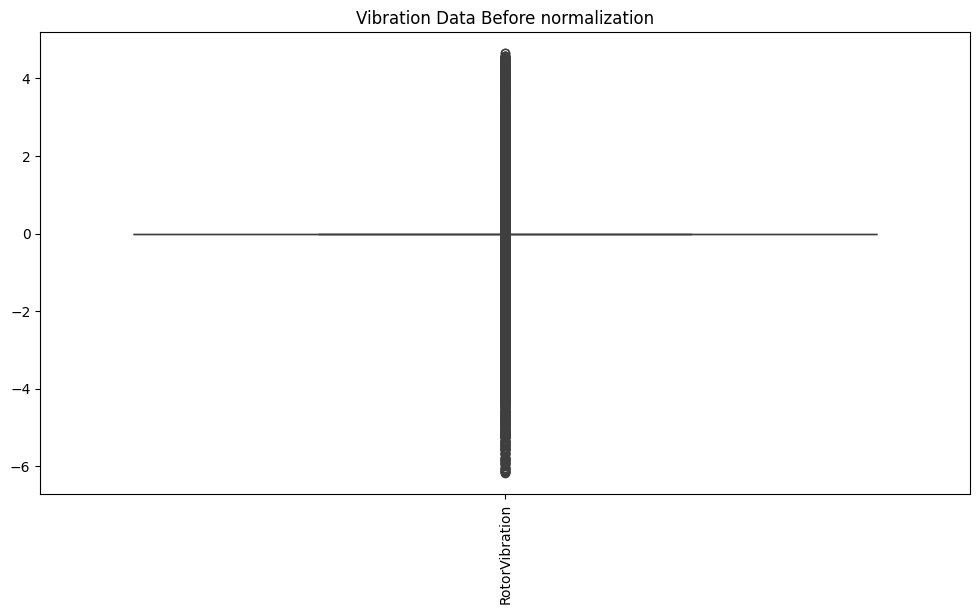

In [7]:
# Visualize data using box plots
def visualize_data(data, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Visualize data before outlier removal
visualize_data(current_data.iloc[:, 1:], "Current Data Before normalization")
visualize_data(vibration_data.iloc[:, 1:], "Vibration Data Before normalization")

### Data normalization using Quantile Transformer

In [8]:
# --- Custom Normalization using Quantile Transformer ---
current_scaler = QuantileTransformer(output_distribution='normal').fit(current_data.iloc[:, 1:])
vibration_scaler = QuantileTransformer(output_distribution='normal').fit(vibration_data.iloc[:, 1:])

current_data_normalized = current_data.copy()
current_data_normalized.iloc[:, 1:] = current_scaler.transform(current_data.iloc[:, 1:])

vibration_data_normalized = vibration_data.copy()
vibration_data_normalized.iloc[:, 1:] = vibration_scaler.transform(vibration_data.iloc[:, 1:])

# Print shapes and first few rows of normalized data for debugging
print("Normalized current_data shape:", current_data_normalized.shape)
print("Normalized vibration_data shape:", vibration_data_normalized.shape)
print("Normalized current_data head:\n", current_data_normalized.head())
print("Normalized vibration_data head:\n", vibration_data_normalized.head())

# Check the range of normalized values to ensure scaling
print("Range of normalized current_data values:", current_data_normalized.iloc[:, 1:].min().min(), "to", current_data_normalized.iloc[:, 1:].max().max())
print("Range of normalized vibration_data values:", vibration_data_normalized.iloc[:, 1:].min().min(), "to", vibration_data_normalized.iloc[:, 1:].max().max())

Normalized current_data shape: (2100007, 7)
Normalized vibration_data shape: (2100007, 2)
Normalized current_data head:
      Time  RotorSpeed      V_ab       I_a       I_b       I_c  OutputTorque
0  0.0000    5.199337 -5.199337 -5.199337 -5.199337 -5.199337      0.024081
1  0.0005    5.199337 -5.199337 -5.199337 -5.199337 -5.199337      1.028018
2  0.0010    5.199337 -5.199337 -5.199337 -5.199337 -5.199337      0.677476
3  0.0015    5.199337 -5.199337 -5.199337 -5.199337 -5.199337      1.160024
4  0.0020    5.199337 -5.199337 -5.199337 -5.199337 -5.199337      0.904502
Normalized vibration_data head:
      Time  RotorVibration
0  0.0000       -0.032540
1  0.0005       -0.033491
2  0.0010       -0.746428
3  0.0015        1.141712
4  0.0020        0.916583
Range of normalized current_data values: -5.1993375 to 5.1993375
Range of normalized vibration_data values: -5.1993375 to 5.1993375


#### Resampling, interpolating, and correcting the time column

In [9]:
# the time column had to be resmapled and interpolated to maintain a consistent sampling time 


# Remove duplicate values in the 'Time' column to ensure uniqueness
current_data_normalized = current_data_normalized.drop_duplicates(subset='Time')
vibration_data_normalized = vibration_data_normalized.drop_duplicates(subset='Time')

# Convert 'Time' column to TimedeltaIndex for resampling
current_data_normalized['Time'] = pd.to_timedelta(current_data_normalized['Time'], unit='S')
vibration_data_normalized['Time'] = pd.to_timedelta(vibration_data_normalized['Time'], unit='S')

# Resample the data to ensure consistent intervals, then interpolate
current_data_normalized = current_data_normalized.set_index('Time').resample('0.0005S').interpolate().reset_index()
vibration_data_normalized = vibration_data_normalized.set_index('Time').resample('0.0005S').interpolate().reset_index()

# Convert 'Time' column back to float seconds if needed
current_data_normalized['Time'] = current_data_normalized['Time'].dt.total_seconds()
vibration_data_normalized['Time'] = vibration_data_normalized['Time'].dt.total_seconds()

# Print shapes to verify results
print("Current data shape after resampling and interpolation:", current_data_normalized.shape)
print("Vibration data shape after resampling and interpolation:", vibration_data_normalized.shape)


Current data shape after resampling and interpolation: (300001, 7)
Vibration data shape after resampling and interpolation: (300001, 2)


In [ ]:
# Check for consistency in the Time column
time_diffs = current_data_normalized['Time'].diff().dropna()
if not np.allclose(time_diffs, 0.0005):
    print("Inconsistent time intervals detected.")
    print(time_diffs[~np.isclose(time_diffs, 0.0005)])

### Creating data sequences

In [14]:
# Set sequence length and overlap
sequence_length = 100
overlap = 0.2

# Step 1: Ensure regular time intervals by interpolating any missing time values
def regularize_time(data, interval='500U'): # 500 microseconds = 0.0005 seconds
    data['Time'] = pd.to_datetime(data['Time'], unit='s')
    data = data.set_index('Time').resample(interval).interpolate().reset_index()
    return data

# Apply to both current and vibration data
current_data_normalized = regularize_time(current_data_normalized)
vibration_data_normalized = regularize_time(vibration_data_normalized)

# Step 2: Sequence generation with realignment
def create_continuous_sequences(data, sequence_length, overlap=0.5):
    step = int(sequence_length * (1 - overlap))
    sequences = []
    for i in range(0, len(data) - sequence_length + 1, step):
        seq = data.iloc[i:i + sequence_length].values
        # Realign start of the sequence to match the end of the last if there's a discontinuity
        if i > 0 and not np.allclose(sequences[-1][-1], seq[0], atol=1e-6):
            seq[0] = sequences[-1][-1]
        sequences.append(seq)
    return np.array(sequences)

# Generate sequences for current and vibration data
current_sequences = create_continuous_sequences(current_data_normalized.iloc[:, 1:], sequence_length, overlap=overlap)
vibration_sequences = create_continuous_sequences(vibration_data_normalized.iloc[:, 1:], sequence_length, overlap=overlap)

# Step 3: Split data into training and validation sets
split_index = int(len(current_sequences) * 0.8)  # Ensure training set is larger
train_current_seq = current_sequences[:split_index]
val_current_seq = current_sequences[split_index:]
train_vibration_seq = vibration_sequences[:split_index]
val_vibration_seq = vibration_sequences[split_index:]

# Step 4: Generate RUL values based on time using consistent intervals for both train and val sets
train_rul_start = (current_data_normalized['Time'].iloc[sequence_length - 1] - pd.Timestamp("1970-01-01")) / pd.Timedelta(seconds=1)
train_rul = np.arange(train_rul_start, train_rul_start + len(train_current_seq) * 0.0005, 0.0005)[:len(train_current_seq)]
train_rul = np.round(train_rul / 0.0005) * 0.0005  # Round to nearest 0.0005 for consistency
train_rul = train_rul.astype(np.float32)

val_rul_start = train_rul[-1] + 0.0005  # Start validation RUL where training RUL ends
val_rul = np.arange(val_rul_start, val_rul_start + len(val_current_seq) * 0.0005, 0.0005)[:len(val_current_seq)]
val_rul = np.round(val_rul / 0.0005) * 0.0005  # Round to nearest 0.0005 for consistency
val_rul = val_rul.astype(np.float32)

# Diagnostic prints to verify shapes and consistency
print("train_current_seq shape:", train_current_seq.shape)
print("train_vibration_seq shape:", train_vibration_seq.shape)
print("train_rul shape:", train_rul.shape)
print("val_current_seq shape:", val_current_seq.shape)
print("val_vibration_seq shape:", val_vibration_seq.shape)
print("val_rul shape:", val_rul.shape)
print("First few rows of train_rul:\n", train_rul[:10])
print("First few rows of val_rul:\n", val_rul[:10])

# Create a data generator
def data_generator(current_seq, vibration_seq, rul):
    for i in range(len(current_seq)):
        yield (current_seq[i], vibration_seq[i]), rul[i]

batch_size = 16

# Define TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_current_seq, train_vibration_seq, train_rul),
    output_signature=(
        (tf.TensorSpec(shape=(sequence_length, 6), dtype=tf.float32),
         tf.TensorSpec(shape=(sequence_length, 1), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(batch_size).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_current_seq, val_vibration_seq, val_rul),
    output_signature=(
        (tf.TensorSpec(shape=(sequence_length, 6), dtype=tf.float32),
         tf.TensorSpec(shape=(sequence_length, 1), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(batch_size).repeat()

# Verify dataset structure
for data, label in train_dataset.take(1):
    print("Batch data shapes:", [d.shape for d in data], "Batch label shape:", label.shape)
    print("Batch data types:", [d.dtype for d in data], "Batch label dtype:", label.dtype)

for data, label in val_dataset.take(1):
    print("Batch data shapes:", [d.shape for d in data], "Batch label shape:", label.shape)
    print("Batch data types:", [d.dtype for d in data], "Batch label dtype:", label.dtype)


train_current_seq shape: (2999, 100, 6)
train_vibration_seq shape: (2999, 100, 1)
train_rul shape: (2999,)
val_current_seq shape: (750, 100, 6)
val_vibration_seq shape: (750, 100, 1)
val_rul shape: (750,)
First few rows of train_rul:
 [0.0495 0.05   0.0505 0.051  0.0515 0.052  0.0525 0.053  0.0535 0.054 ]
First few rows of val_rul:
 [1.549  1.5495 1.55   1.5505 1.551  1.5515 1.552  1.5525 1.553  1.5535]
Batch data shapes: [TensorShape([16, 100, 6]), TensorShape([16, 100, 1])] Batch label shape: (16,)
Batch data types: [tf.float32, tf.float32] Batch label dtype: <dtype: 'float32'>
Batch data shapes: [TensorShape([16, 100, 6]), TensorShape([16, 100, 1])] Batch label shape: (16,)
Batch data types: [tf.float32, tf.float32] Batch label dtype: <dtype: 'float32'>


#### Checking the validation data sequencing and consistency

In [15]:
# Check 1: Validation sequence consistency
def check_sequence_consistency(data, sequence_length):
    for i in range(len(data) - 1):
        # Ensure each sequence is following the previous one by 'sequence_length'
        if not np.allclose(data[i][-1], data[i + 1][0], atol=1e-6):
            print(f"Inconsistency found between sequence {i} and {i+1}")
            return False
    print("Validation sequence consistency check passed.")
    return True

# Check validation sequences for consistency
print("Checking validation current sequence consistency...")
check_sequence_consistency(val_current_seq, sequence_length)

print("Checking validation vibration sequence consistency...")
check_sequence_consistency(val_vibration_seq, sequence_length)

# Check 2: Validation RUL Sampling Consistency
def check_rul_sampling_consistency(rul, expected_interval=0.0005):
    diff = np.diff(rul)
    if np.allclose(diff, expected_interval, atol=1e-6):
        print("Validation RUL sampling consistency check passed.")
        return True
    else:
        print(f"Inconsistent time intervals in validation RUL. Expected {expected_interval}, but found variations.")
        return False

# Check validation RUL time interval consistency
print("Checking validation RUL sampling consistency...")
check_rul_sampling_consistency(val_rul)

# Check 3: Validate Sequential Data Split
def validate_data_split(train_rul, val_rul):
    if len(train_rul) == 0:
        print("Warning: train_rul is empty. Check the data splitting logic.")
        return False
    if len(val_rul) == 0:
        print("Warning: val_rul is empty. Check the data splitting logic.")
        return False
    if train_rul[-1] < val_rul[0]:
        print("Data split check passed. Validation data follows training data in time.")
        return True
    else:
        print("Data split check failed. Validation data does not follow training data in time.")
        return False

# Check if validation data is sequentially after training data
print("Checking validation data split...")
validate_data_split(train_rul, val_rul)

# Check 4: Batch Size and Sequence Length Consistency in Data Generator
def check_batch_size_sequence_length(dataset, expected_batch_size, expected_sequence_length, num_batches=5):
    for batch_data, _ in dataset.take(num_batches):
        current_seq, vibration_seq = batch_data
        if current_seq.shape[0] != expected_batch_size or vibration_seq.shape[0] != expected_batch_size:
            print(f"Inconsistent batch size found: {current_seq.shape[0]} instead of {expected_batch_size}")
            return False
        if current_seq.shape[1] != expected_sequence_length or vibration_seq.shape[1] != expected_sequence_length:
            print(f"Inconsistent sequence length found: {current_seq.shape[1]} instead of {expected_sequence_length}")
            return False
    print("Batch size and sequence length consistency check passed.")
    return True

# Run the batch size and sequence length consistency check on validation dataset
expected_batch_size = 16
expected_sequence_length = 100

print("Checking validation batch size and sequence length consistency...")
check_batch_size_sequence_length(val_dataset, expected_batch_size, expected_sequence_length)

Checking validation current sequence consistency...
Validation sequence consistency check passed.
Checking validation vibration sequence consistency...
Validation sequence consistency check passed.
Checking validation RUL sampling consistency...
Validation RUL sampling consistency check passed.
Checking validation data split...
Data split check passed. Validation data follows training data in time.
Checking validation batch size and sequence length consistency...
Batch size and sequence length consistency check passed.


True

## Custom Time and Channel attention layer functions

In [16]:
# Define custom layers for time and channel attention
class TimeAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(TimeAttentionLayer, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.W_h = tf.keras.layers.Dense(hidden_size)
        self.W_t = tf.keras.layers.Dense(hidden_size)
        self.v = tf.keras.layers.Dense(1)

    def call(self, inputs):
        h_t = inputs
        u_t = tf.nn.tanh(self.W_h(h_t) + tf.expand_dims(self.W_t(h_t[:, -1, :]), axis=1))
        a_t = tf.nn.softmax(self.v(u_t), axis=1)
        S_t = tf.reduce_sum(a_t * h_t, axis=1)
        return S_t

    def get_config(self):
        config = super(TimeAttentionLayer, self).get_config()
        config.update({"hidden_size": self.hidden_size})
        return config

class ChannelAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.num_channels = num_channels
        self.W_v = tf.keras.layers.Dense(num_channels)
        self.W_m = tf.keras.layers.Dense(num_channels)
        self.W_n = tf.keras.layers.Dense(num_channels)
        # Adjust the output dimension of W_a to 1 for a single attention weight
        self.W_a = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        H = inputs
        v_j = GlobalAvgPool1D()(H)
        m_j = GlobalMaxPooling1D()(H)
        n_j = tf.reduce_sum(H, axis=1)
        concatenated = tf.concat([v_j, m_j, n_j], axis=1)
        r = tf.nn.relu(self.W_v(concatenated) + self.W_m(concatenated) + self.W_n(concatenated))
        # Calculate a single attention weight for the entire time series
        attention_weight = self.W_a(r)
        # Apply attention weight to the input H
        attention_output = attention_weight * H
        return attention_output # Output maintains the shape of H

    def get_config(self):
        config = super(ChannelAttentionLayer, self).get_config()
        config.update({"num_channels": self.num_channels})
        return config

# Define a custom layer for expand_dims
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

    def get_config(self):
        config = super(ExpandDimsLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

class SqueezeLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(SqueezeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        # Handle the batch dimension
        if inputs.shape[self.axis] == 1:
            return tf.squeeze(inputs, axis=self.axis)
        else:
            return inputs  # Return the input as is if the dimension is not 1

    def get_config(self):
        config = super(SqueezeLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

    def compute_output_shape(self, input_shape):
        # Handle the case where the axis is squeezed
        if input_shape[self.axis] == 1:
            output_shape = list(input_shape)
            del output_shape[self.axis]
            return tuple(output_shape)
        else:
            return input_shape  # Return the original shape if not squeezing

## Model building with Bayesian Optimization Hyperparameter tuning

In [17]:
# input shape for stator and rotor data
stator_input_shape = (100, 6) # (sequence_length, number of stator features)
rotor_input_shape = (100, 1) # (sequence_length, number of rotor features)

# Define a custom composite loss function (MSE + MAE)
def composite_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    return mse_loss + mae_loss

# Set up directories for TensorBoard logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")

# Model building function
def build_model(hidden_size, dropout_rate, dense_size, learning_rate):
    # Stator current input
    input_stator = Input(shape=(100, 6), name='stator_input')
    lstm_stator = Bidirectional(LSTM(hidden_size, return_sequences=True))(input_stator)
    time_attention_stator = TimeAttentionLayer(hidden_size)(lstm_stator)

    # Rotor vibration input
    input_rotor = Input(shape=(100, 1), name='rotor_input')
    lstm_rotor = Bidirectional(LSTM(hidden_size, return_sequences=True))(input_rotor)
    time_attention_rotor = TimeAttentionLayer(hidden_size)(lstm_rotor)

    # Concatenate and Dense layers with Dropout
    concatenated = Concatenate()([time_attention_stator, time_attention_rotor])
    expanded = ExpandDimsLayer(axis=1)(concatenated)
    channel_attention_layer = ChannelAttentionLayer(hidden_size * 2)(expanded)
    squeezed = SqueezeLayer(axis=1)(channel_attention_layer)
    dense1 = Dense(dense_size, activation='relu')(squeezed)
    dropout1 = Dropout(dropout_rate)(dense1)
    output = Dense(1)(dropout1)

    model = Model(inputs=[input_stator, input_rotor], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=composite_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Print model summary for debugging
    model.summary()

    return model

import time

# Define the hyperparameter space
space  = [
    Integer(32, 128, name='hidden_size'),
    Real(0.2, 0.6, name='dropout_rate'),
    Integer(32, 128, name='dense_size'),
    Real(1e-5, 1e-3, "log-uniform", name='learning_rate')
]

# Initialize best_model and minimum validation loss globally
best_model = None
best_history = None
best_val_loss = float('inf')  # Track the lowest validation loss

# Objective function for Bayesian optimization
@use_named_args(space)
def objective(hidden_size, dropout_rate, dense_size, learning_rate):
    global best_model, best_history, best_val_loss

    model = build_model(hidden_size, dropout_rate, dense_size, learning_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    # Define TensorBoard callback with unique log directory for each run
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        steps_per_epoch=len(train_current_seq) // batch_size,
        validation_steps=len(val_current_seq) // batch_size,
        epochs=50,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )

    val_loss = min(history.history['val_loss'])

    # Update best_model if the current model has a lower validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history
    return val_loss

# Perform Bayesian optimization
result = gp_minimize(objective, space, n_calls=10, random_state=42)

# Display the best hyperparameters with detailed labels and formatting
print("\nBest Hyperparameters:")
print(f" - Hidden Layer Size (LSTM): {result.x[0]}")
print(f" - Dropout Rate: {result.x[1]:.4f}")
print(f" - Dense Layer Size: {result.x[2]}")
print(f" - Learning Rate: {result.x[3]:.6f}")
print(f"Best validation loss: {best_val_loss}")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stator_input (InputLayer)      [(None, 100, 6)]     0           []                               
                                                                                                  
 rotor_input (InputLayer)       [(None, 100, 1)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 216)     99360       ['stator_input[0][0]']           
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100, 216)    95040       ['rotor_input[0][0]']            
 )                                                                                            

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit


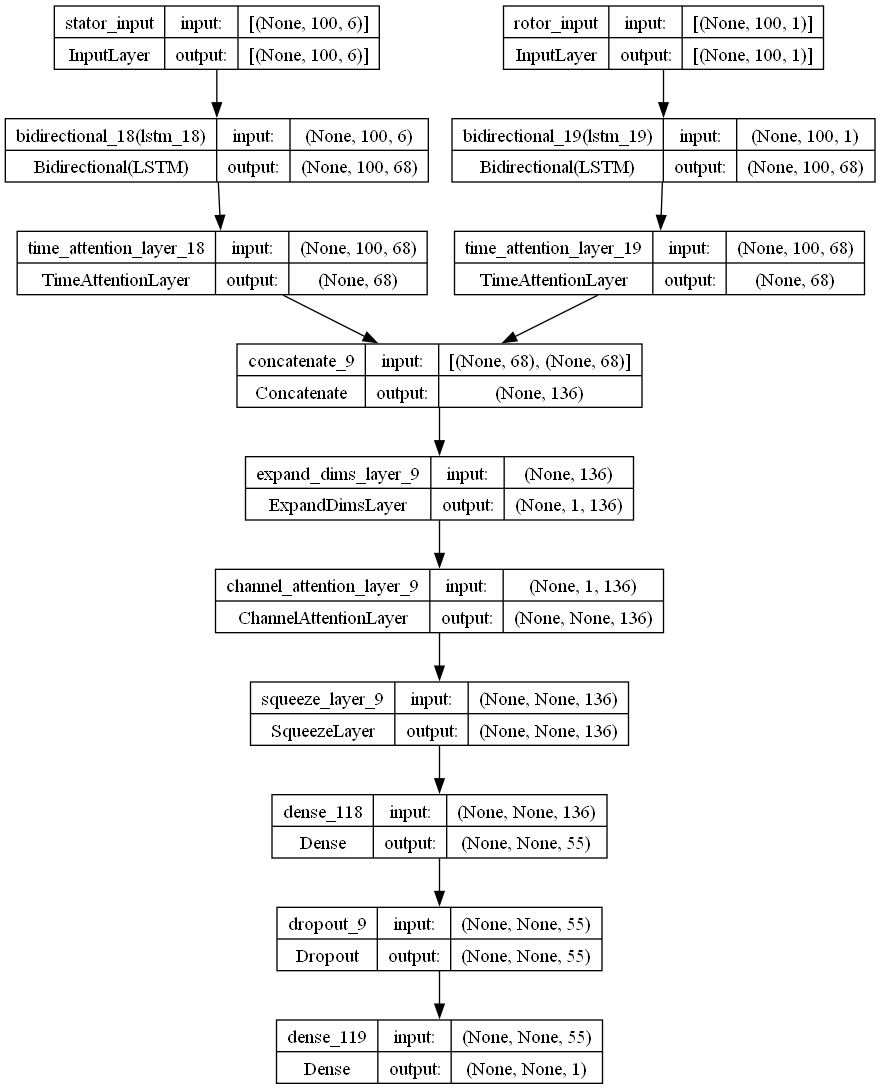

In [19]:
# Visualize the model architecture
plot_model(best_model, to_file='DL_model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architecture image if running in a Jupyter Notebook
from IPython.display import Image
Image(filename='DL_model_architecture.png')

## Performance Assessment of Trained model

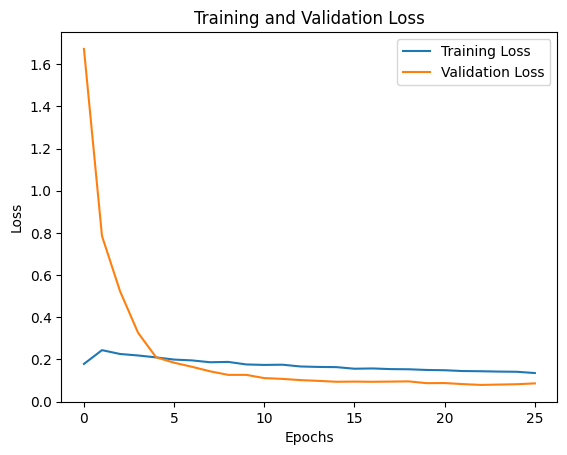

In [20]:
# Training and validation loss curves - this can help us see if the model is
# overfitting, underfitting, or performing well on both training and validation sets.

history = best_model.history # Get the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Saving the trained model

In [23]:
#save the model locally

best_model.save('MCA_BiLSTM_RUL_model.h5')  # Save as HDF5 file
best_model.save('MCA_BiLSTM_RUL_model.keras')  # Save as Keras model format

# exporting only the weights
best_model.save_weights('MCA_BiLSTM_RUL_model_weights.weights.h5')
